# Intruduction to LangGraph   
https://github.com/langchain-ai/langgraph/blob/main/examples/introduction.ipynb

In [2]:
# Setting up environment
from dotenv import load_dotenv
load_dotenv(r'D:\git\plinio_assistant\.env')

True

In [3]:
from typing import Annotated # This is what will allow us to pass the reductor function to our State class

from typing_extensions import TypedDict # So we can better 'lock' the datatypes for our state attributes

from langgraph.graph import StateGraph # The main structure of our graph
from langgraph.graph.message import add_messages # This is a prebuilt function that does the reductor job. Could be manually implemented.

In [4]:
# Creating the State class
class State(TypedDict):
    """
    The State class is a TypedDict that will hold the attributes of our state.
    The add_messages reductor function will guarantee that when a node simply returns the new message, it is appended instead of replacing the previous ones.
    """
    messages: Annotated[list, add_messages]

# As an additional consideration, the states should always have a a key-value structure.
# The reason to use TypedDicts or Pydantic models is to create additional validation when needed.

In [5]:
# This is the main structure of our graph. 
# We first create the 'scafolding' for it, so we can add the nodes and edges later.
# When we're done, we will .compile() it.
# These are based on NetworkX, so there's some graph traversal logic that makes sense here.

graph_builder = StateGraph(State)
# Ok, so what does this do: it prepares said 'scafolding'.
# But more importantly, is says that every node in the graph MUST receive the state as an input.
# Secondly, the nodes should return just the UPDATEs to the state, that'll be applied using the reductor function.
# They shouldnt return the whole state, just the updates.

In [6]:
# Now for an llm itself.
# The tutorial uses Anthropic, I'll use OpenAI

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [7]:
# This will be the first node of our graph.
# Nodes are callables. That's it.
# If it happens to be a model, good for them.

def chatbot_node_callable(state: State):
    """
    This will 'simply' invoke the model. The tutorial defines it in one line:
    return {"messages":[llm.invoke(state["messages"])]}
    but I'll split it up for clarity.

    Inputs:
    state: State > Note that it receives the FULL state. The graph is responsible for passing the correct attributes to the node (in this case, the state).

    Outputs:
    A key-value pair that'll be 'applied' to the state using the reductor function.
    There is no need to return the entire state schema, just the updates.
    In this case, we're updating the messages attribute, so:
    return {"messages": [The output of the model]}

    Note: The value should be a list, because the add_message reductor function is a beefed up version of list.extend().
    """
    # Models except a list of messages when invoked, at least in this context.
    messages = state["messages"] # They are stored here, so we get them
    response = llm.invoke(messages) # And pass them to the model
    # The response for these messages is an instance of BaseMessage, implemented in the langchain library.
    # Since langchain takes care of handling different types of messages (AIMessage, HumanMessage etc) we can use that abstraction
    # and simply append it.
    return {"messages": [response]} # Remembering to send it back as a list.

    # Later addition: from reading the add_message docs it _apparently_ accepts a single message as well.
    # Will try this when we run the graph.

In [8]:
# Now we start building on top of the scafolding.
# We add the node to the graph.

graph_builder.add_node('chatbot', chatbot_node_callable)

In [9]:
# We need to set the entry and finish points of our graph.
# Pretty sure the finish point is optional, and the graph just infers it from the last node in a sequence.
# But being explicit is always a good idea.

graph_builder.set_entry_point('chatbot') # A good convenience (courtesy of NetworkX) is that we can use the node name instead of the callable.
graph_builder.set_finish_point('chatbot')

In [10]:
# Great. Now its time to compile the graph.
# This'll allow us to actually use it.

graph = graph_builder.compile()

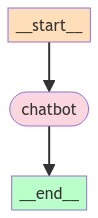

In [11]:
# Now this is a great helper function to visualize the graph.
# Should probably wrap it in a callable as well at some point.

from IPython.display import Image, display # Also, these imports should be at the top of an official .py; This is just a notebook tho.

try:
    display(Image(graph.get_graph().draw_mermaid_png())) # Also notice the get_graph() method is from the CompiledGraph class, not the StateGraph one.
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
# Adapting a bit the tutorial, I'll use both the invoke and the stream methods.
# Invoking runs everything before returning.

# To start, we need the user input
# In this first try I'll use langchain's HumanMessage class.
from langchain_core.messages import HumanMessage

user_input = HumanMessage("Hello, how are you?")

# Now remember, we must respect the schema the State class is expecting.
# In this case, it's a dictionary with a list of messages, so the reductor function can work its magic.
# I'm being unecessarily verbose here, but it's for clarity.
first_input = {"messages": [user_input]}
invocation_response = graph.invoke(first_input)

# Now we can print the response.
# Also for clarity, let's print the entire thing in a more pretty way.

from pprint import pprint
pprint(invocation_response)

{'messages': [HumanMessage(content='Hello, how are you?', id='05bd5810-26f7-4718-9c28-d83abd9e2dfb'),
              AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with whatever you need. How can I assist you today?", response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 13, 'total_tokens': 47}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ce0793330f', 'finish_reason': 'stop', 'logprobs': None}, id='run-5bcc3e7e-4b4b-4002-bd4a-2801830a00af-0', usage_metadata={'input_tokens': 13, 'output_tokens': 34, 'total_tokens': 47})]}


In [18]:
# Great. The response is also there, with the usual metadata.
# Just for clarity, what was returned was not a dict, it was the datatype from the state, but NOT the state.
# Pretty messy.
# TODO: Figure this out.

print(type(invocation_response))

<class 'langgraph.pregel.io.AddableValuesDict'>


In [19]:
# As I mentioned when building the graph, apparently the add_message reductor function can accept a single message.
# Let's try that, but that means I'll have to rebuild the graph to use the different node.
single_message_graph_builder = StateGraph(State)
def chatbot_node_single_message_callable(state: State):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": response} # This is the difference.

single_message_graph_builder.add_node('chatbot', chatbot_node_single_message_callable)
single_message_graph_builder.set_entry_point('chatbot')
single_message_graph_builder.set_finish_point('chatbot')
single_message_graph = single_message_graph_builder.compile()

# Now we can invoke it again.
first_input_single_message = {"messages": user_input} # I can use the same input as before.
invocation_response_single_message = single_message_graph.invoke(first_input_single_message)

In [20]:
# Wouldn't you know it, it worked.
print(invocation_response_single_message)

{'messages': [HumanMessage(content='Hello, how are you?', id='05bd5810-26f7-4718-9c28-d83abd9e2dfb'), AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 13, 'total_tokens': 43}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ce0793330f', 'finish_reason': 'stop', 'logprobs': None}, id='run-54411f4e-87ba-4e84-b52f-4acdbeddc5e0-0', usage_metadata={'input_tokens': 13, 'output_tokens': 30, 'total_tokens': 43})]}


In [22]:
# This is also an insane convenience given the Annotated nature of the State, plus the BaseMessage class:
# we can simply pass a tuple of (role, message) and it'll figure it out.
# I GUESS it is using this method behind the scenes: 
# https://api.python.langchain.com/en/latest/messages/langchain_core.messages.utils.convert_to_messages.html#langchain_core.messages.utils.convert_to_messages
# But I'm not sure how it is identifying the need to use it.

# Let's use the latter graph, to see if the convenience works in conjunction with the reductor function.
first_input_tuple = {"messages": ('user','Howdy, good sir!')} # The tuple.

invocation_response_tuple = single_message_graph.invoke(first_input_tuple)

In [23]:
# Apparently also worked. God bless abstractions.
print(invocation_response_tuple)

{'messages': [HumanMessage(content='Howdy, good sir!', id='4090cc66-bffc-4442-863f-1ad2c6447ab3'), AIMessage(content='Well, howdy to you too! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 12, 'total_tokens': 27}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ce0793330f', 'finish_reason': 'stop', 'logprobs': None}, id='run-4abfde2d-19a1-4328-820f-cd84320d72fe-0', usage_metadata={'input_tokens': 12, 'output_tokens': 15, 'total_tokens': 27})]}


In [24]:
# Now for the streaming method.
# Expecting the same behavior, so I'll focus on the second example: using a BaseMessage subclass, but adding without a list.

# The .stream() method returns an iterator.
for event in single_message_graph.stream(first_input_single_message): # Using the single message graph, and the original input
    print(event) # The introduction notebook prints a .value attribute, but for starters I'll just print the event itself.

{'chatbot': {'messages': AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?", response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 13, 'total_tokens': 43}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_4008e3b719', 'finish_reason': 'stop', 'logprobs': None}, id='run-da35e920-27b4-4e5b-bafd-8901e35c87bd-0', usage_metadata={'input_tokens': 13, 'output_tokens': 30, 'total_tokens': 43})}}


In [25]:
# Not that exciting for a single node graph.

# This concludes the basic graph building and invocation.

In [26]:
# Part 2: TOOLS!
# The tutorial uses pre-built tools (namely, TavilySearch).
# I'll do that, but also will try to implement a custom tool since that is what I'll need for my actual project.

In [27]:
# As a starter, the tutorial already fetches and instantiates a tool object.
from langchain_community.tools.tavily_search import TavilySearchResults

# Creating the actual tool instance
tool = TavilySearchResults(max_results=3)

# We can test it, since tools also contain the .invoke() method.
# Those langchain folks are really into the invoke method, huh? (This was written by Copilot. Not this parethesis. (This one was.))
tool.invoke("What is the answer to life, the universe and everything else?")

[{'url': 'https://news.mit.edu/2019/answer-life-universe-and-everything-sum-three-cubes-mathematics-0910',
  'content': 'Suggestions or feedback?\nMIT News | Massachusetts Institute of Technology\nBrowse By\nTopics\nDepartments\nCenters, Labs, & Programs\nSchools\nThe answer to life, the universe, and everything\nPress Contact:\nPrevious image\nNext image\nA team led by Andrew Sutherland of MIT and Andrew Booker of Bristol University has solved the final piece of a famous 65-year old math puzzle with an answer for the most elusive number of all: 42.\n The method of using Charity Engine is similar to part of the plot surrounding the number 42 in the "Hitchhiker" novel: After Deep Thought’s answer of 42 proves unsatisfying to the scientists, who don’t know the question it is meant to answer, the supercomputer decides to compute the Ultimate Question by building a supercomputer powered by Earth … in other words, employing a worldwide massively parallel computation platform.\n “It’s very g

In [28]:
# I'll reuse the State class.
tool_graph_builder = StateGraph(State)

In [30]:
# Here's another langchain convenience:
# You can use the bind_tools method from a model Chat class to bind tools to it.
# Langchain figures out how to represent that in the way the model needs (usually those OpenAPI syntaxes).

llm = ChatOpenAI(model='gpt-4o')
llm_with_tools = llm.bind_tools([tool]) # It does expect a list.

In [31]:
# Next we create the callable that we'll use in the node.

def chatbot_with_tools(state: State):
    # Once again, unnecessary verbosity for clarity.
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": response}

In [32]:
# Adding to the graph.
tool_graph_builder.add_node('chatbot', chatbot_with_tools)

In [33]:
# This next step actually exemplifies a common missconception about LLMs:
# The LLM doesn't ITSELF call functions. It requests the code to call the functions using the parameters it provides.
# What that means is that we need to have something that'll interpret the AIMessage's tool_call requests and call them.

# I'll be honest here and say that the introduction implements a ToolNode from scratch, for instructive purposes.
# I don't feel like doing that so I'll just jump ahead to using their actual ToolNode implementation.
# The implementation runs toolcalls in parallel by default, so why not.
# TODO: Understand how NOT to do that, maybe given return dependencies.

from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=[tool]) # https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode

# Here's something worth saying again: We need BOTH to bind the tools to the model (so that it knows what it has at its disposal),
# AND create a tool node (that'll be expecting the tool_calls and runs them).

tool_graph_builder.add_node('tools', tool_node)

In [34]:
# We don't necessarily want the tools to be called everytime, much like regular model usage.
# We thus need to implement some conditions. That's there conditional_edges come in.

# They are edges that receive the FULL state of the graph, operate over it by using a callable, and return a value.
# The conditional_edge then also has a key-value pair, in which the keys are the possible returns, and the values are the edges to be followed.

# Let's first create the callable that'll be used in the conditional edge.
from typing import Literal

def route_tools(state: State,) -> Literal["tools","__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    The values returned here are arbitrary, but it makes sense to name them after the node in the graph they should route to.
    """

    # First we must get the last message from the state.
    # We are looking necessarily for an AIMessage, since those are the ones that call tools.
    # The introduction notebook adds a few validation if-elses, some of which are unnecessary.

    # A try-except solves my current needs
    try:
        last_message = state["messages"][-1]
    except: 
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # Now we check if the last message has tool calls.
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools" # Logic being: 'Look, there's a tool call. So we should route to the 'tools' node.
    return "__end__"

In [35]:
# Now the conditional edge.
# It has three components: its name, the callable to 'make the decision', and the key-value mapping of the possible returns.

tool_graph_builder.add_conditional_edges('chatbot', route_tools, {"tools": "tools", "__end__": "__end__"})

# Note there's the mapping at the end there.
# If the values (as is this case) returned by the router function are themselves node names, we can ommit that.
# So in our current case, this is equivalent:

# tool_graph_builder.add_conditional_edges('chatbot', route_tools)

In [36]:
# Since the point of tool_calling is helping the assistant, we need to send the result back to the agent.

tool_graph_builder.add_edge('tools', 'chatbot')

In [37]:
# Now for boiler plate compiling

tool_graph_builder.set_entry_point('chatbot')

tool_graph = tool_graph_builder.compile()

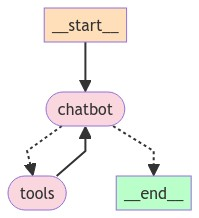

In [38]:
# Once again visualizing the graph

from IPython.display import Image, display

try:
    display(Image(tool_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [43]:
# I'll stick to streaming from now on, so I can see each interaction.
# This for loop is from the notebook.
# By the way, the notebook implements a while True loop to keep the conversation going. That's unnecessary for now.

from langchain_core.messages import BaseMessage # Quick import to use as a logical test.

user_input = HumanMessage("Good morning!") # I'll first try with something that doesn't need a tool call.

for event in tool_graph.stream({"messages": user_input}):
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage): # We get the last message per print since the streaming method returns the full state at every step.
            print("Assistant:", value["messages"][-1].content)

TypeError: 'AIMessage' object is not subscriptable

In [45]:
# Let's see what went wrong, by printing everything
for event in tool_graph.stream({"messages": user_input}):
    print(event)

{'chatbot': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_oxuCfDtUMAkrGFPcGjK5Xgik', 'function': {'arguments': '{"query":"Brazil\'s president in 1987"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 92, 'total_tokens': 116}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ce0793330f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7879a4dd-e15c-4b5c-8bcb-e4e04e145937-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': "Brazil's president in 1987"}, 'id': 'call_oxuCfDtUMAkrGFPcGjK5Xgik'}], usage_metadata={'input_tokens': 92, 'output_tokens': 24, 'total_tokens': 116})}}
{'tools': {'messages': [ToolMessage(content='[{"url": "https://en.wikipedia.org/wiki/List_of_presidents_of_Brazil", "content": "In 1997, a Constitutional Amendment was enacted allowing presidents of Brazil to be reelected to one consecutive term. In 

In [47]:
# So, at some points messages contains a list of messages, and at others it's just a single message.
# Guess this has something to do with my decision earlier to sometimes pass only a single message.

user_input = HumanMessage("Good morning!") # I'll first try with something that doesn't need a tool call.

for event in tool_graph.stream({"messages": user_input}):
    for value in event.values():
        if isinstance(value["messages"], BaseMessage): # Single message case.
            print("Assistant:", value["messages"].content)
        elif isinstance(value["messages"][-1], BaseMessage): # Multi-message case.
            print("Assistant:", value["messages"][-1].content)

Assistant: Good morning! How can I assist you today?


In [48]:
# Now something that takes research to answer.

user_input = HumanMessage("What's the diameter of the moon?") 

for event in tool_graph.stream({"messages": user_input}):
    for value in event.values():
        if isinstance(value["messages"], BaseMessage): # Single message case.
            print("Assistant:", value["messages"].content)
        elif isinstance(value["messages"][-1], BaseMessage): # Multi-message case.
            print("Assistant:", value["messages"][-1].content)

Assistant: The diameter of the Moon is approximately 3,474 kilometers (2,159 miles).


In [49]:
# Apparently it didn't search online. I'll be more explicit.

user_input = HumanMessage("What's the diameter of the moon? Please search online before answering.") 

for event in tool_graph.stream({"messages": user_input}):
    for value in event.values():
        if isinstance(value["messages"], BaseMessage): # Single message case.
            print("Assistant:", value["messages"].content)
        elif isinstance(value["messages"][-1], BaseMessage): # Multi-message case.
            print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"url": "https://www.moongiant.com/phase/today/", "content": "Phase Details for - December 1\nUseful Moon Resources\nCheck the weather before a night of Moon gazing at weather.com\nFor a list of all the current meteor showers visit American Meteor Society\nWaning Gibbous Moonrise and Moonset It takes 29.53 days for the Moon to orbit the Earth and go through the lunar cycle of all 8 Moon phases.\n The average Moon rise for this phase is between 9pm and Midnight depending on the age of the phase. It lasts roughly 7 days with the Moon\u2019s illumination growing smaller each day until the Moon becomes a Last Quarter Moon with an illumination of 50%. Visit the\nDecember 2023 Moon Phases Calendar to see all the daily moon phase for this month.\n"}, {"url": "https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html", "content": "Moon ; Semimajor axis (10 6 km) 0.3844: Perigee (10 6 km)* 0.3633: Apogee (10 6 km)* 0.4055: Revolution period (days) 27.3217: Synodic pe

In [51]:
# Nice, it works!
# Now before going to the next step, I'll try to implement a custom tool.

In [54]:
# The documentation suggests starting with the @tool decorator.
# https://python.langchain.com/v0.2/docs/how_to/custom_tools/

from langchain_core.tools import tool

# I'll start from the begining with a relatively complex tool: reading airtable records.
# While this may be too complex to start with, it is what I need them for.

# This is the standard function.
# https://pyairtable.readthedocs.io/en/stable/getting-started.html
import os
from pyairtable import Api

def read_all():
    api = Api(os.environ['AIRTABLE_ACCESS_TOKEN'])
    table = api.table(os.environ['AIRTABLE_BASE_ID'], 'Tasks')
    return table.all()

# And calling it
print(read_all())

[{'id': 'rec1TD1grkTYegJOW', 'createdTime': '2024-06-20T01:13:23.000Z', 'fields': {'unique_id': 102, 'Task': 'Verificar os barulhos estranhos do carro', 'Status': 'A iniciar', 'Calculation': 'rec1TD1grkTYegJOW'}}, {'id': 'recA6GG38QaR7UJRt', 'createdTime': '2024-06-02T20:18:08.000Z', 'fields': {'unique_id': 97, 'Task': 'Abrir uma loja', 'Status': 'Concluída', 'Calculation': 'recA6GG38QaR7UJRt'}}, {'id': 'recaYhoaEPgyfBDGB', 'createdTime': '2024-06-02T20:18:08.000Z', 'fields': {'unique_id': 98, 'Task': 'Fazer um bolo', 'Status': 'Concluída', 'Calculation': 'recaYhoaEPgyfBDGB'}}, {'id': 'recmZ1HDewckiLjI1', 'createdTime': '2024-06-09T13:57:07.000Z', 'fields': {'unique_id': 99, 'Task': 'Fazer um resumo de tudo que aconteceu essa semana', 'Status': 'A iniciar', 'Calculation': 'recmZ1HDewckiLjI1'}}, {'id': 'recoG6P2qmpneZW4Y', 'createdTime': '2024-06-20T01:11:21.000Z', 'fields': {'unique_id': 100, 'Task': 'Lavar o carro', 'Status': 'Concluída', 'Calculation': 'recoG6P2qmpneZW4Y'}}, {'id': '

In [55]:
# It worked, as it should.
# Now let me start by creating a tool that reads all records from a table.
# As per de documentation, I should add a docstring, as well as type hinting.

from typing import List

@tool # Should be as simple as this
def read_tool() -> List[dict]:
    """
    Gets all tasks currently attributed to the user.
    """
    api = Api(os.environ['AIRTABLE_ACCESS_TOKEN'])
    table = api.table(os.environ['AIRTABLE_BASE_ID'], 'Tasks')
    return table.all()

In [56]:
# It should now have some attributes as a tool.
print(read_tool.name)
print(read_tool.description)
print(read_tool.args)

read_tool
Gets all tasks currently attributed to the user.
{}


In [57]:
# Now let's re-create the tool graph.
# I'll keep the Tavily search tool, but now I'll add the custom tool.

tavily_tool = TavilySearchResults(max_results=3)

tool_graph_builder = StateGraph(State)
toolset = [tavily_tool, read_tool]

llm = ChatOpenAI(model='gpt-4o')
llm_with_tools = llm.bind_tools(tools=toolset) # It does expect a list.

# Next we create the callable that we'll use in the node.

def chatbot_with_tools(state: State):
    # Once again, unnecessary verbosity for clarity.
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": response}

# Adding to the graph.
tool_graph_builder.add_node('chatbot', chatbot_with_tools)

tool_node = ToolNode(tools=toolset) # https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode

tool_graph_builder.add_node('tools', tool_node)

def route_tools(state: State,) -> Literal["tools","__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    The values returned here are arbitrary, but it makes sense to name them after the node in the graph they should route to.
    """

    # First we must get the last message from the state.
    # We are looking necessarily for an AIMessage, since those are the ones that call tools.
    # The introduction notebook adds a few validation if-elses, some of which are unnecessary.

    # A try-except solves my current needs
    try:
        last_message = state["messages"][-1]
    except: 
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # Now we check if the last message has tool calls.
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools" # Logic being: 'Look, there's a tool call. So we should route to the 'tools' node.
    return "__end__"

tool_graph_builder.add_conditional_edges('chatbot', route_tools)

tool_graph_builder.add_edge('tools', 'chatbot')

# Now for boiler plate compiling

tool_graph_builder.set_entry_point('chatbot')

tool_graph = tool_graph_builder.compile()



In [58]:
# Let's try it. First, with a previous working example.

user_input = HumanMessage("What's the diameter of the moon? Please search online before answering.") 

for event in tool_graph.stream({"messages": user_input}):
    for value in event.values():
        if isinstance(value["messages"], BaseMessage): # Single message case.
            print("Assistant:", value["messages"].content)
        elif isinstance(value["messages"][-1], BaseMessage): # Multi-message case.
            print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"url": "https://nineplanets.org/questions/how-big-is-the-moon/", "content": "As, such the top ten biggest moons in the Solar System are Ganymede, Titan, Callisto, Io, Luna (Moon), Europa, Triton, Titania, Rhea, and Oberon.\nFour of the biggest moons in our Solar System belong to the biggest planet in our Solar System, namely Jupiter. Out of the remaining six, two of the biggest moons in the Solar System belong to Saturn, the second biggest planet in the Solar System, and they are Titan and Rhea.\n Top 10 Biggest Moons in the Solar System\nThe top 10 biggest moons in our Solar System are genuinely gigantic, with some of them being even bigger than some of the Solar System\u2019s planets, like Mercury, or they make dwarf planets such as Pluto, Eris, Haumea, Makemake, or Ceres, look small.\n The Moon\u2019s diameter is 3,474 km / 2,158 mi, and it is the biggest Moon in the Solar System relative to the size of its planet.\n The United States is 4,506 km / 2,800 mi 

In [59]:
# Now trying the new tool.

user_input = HumanMessage("What are my tasks?") # Pretty easy, theoretically. 

for event in tool_graph.stream({"messages": user_input}):
    for value in event.values():
        if isinstance(value["messages"], BaseMessage): # Single message case.
            print("Assistant:", value["messages"].content)
        elif isinstance(value["messages"][-1], BaseMessage): # Multi-message case.
            print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"id": "rec1TD1grkTYegJOW", "createdTime": "2024-06-20T01:13:23.000Z", "fields": {"unique_id": 102, "Task": "Verificar os barulhos estranhos do carro", "Status": "A iniciar", "Calculation": "rec1TD1grkTYegJOW"}}, {"id": "recA6GG38QaR7UJRt", "createdTime": "2024-06-02T20:18:08.000Z", "fields": {"unique_id": 97, "Task": "Abrir uma loja", "Status": "Conclu\u00edda", "Calculation": "recA6GG38QaR7UJRt"}}, {"id": "recaYhoaEPgyfBDGB", "createdTime": "2024-06-02T20:18:08.000Z", "fields": {"unique_id": 98, "Task": "Fazer um bolo", "Status": "Conclu\u00edda", "Calculation": "recaYhoaEPgyfBDGB"}}, {"id": "recmZ1HDewckiLjI1", "createdTime": "2024-06-09T13:57:07.000Z", "fields": {"unique_id": 99, "Task": "Fazer um resumo de tudo que aconteceu essa semana", "Status": "A iniciar", "Calculation": "recmZ1HDewckiLjI1"}}, {"id": "recoG6P2qmpneZW4Y", "createdTime": "2024-06-20T01:11:21.000Z", "fields": {"unique_id": 100, "Task": "Lavar o carro", "Status": "Conclu\u00edda", "Calcula

In [60]:
# Awesome!
# Now for my main concern: creating tools that receive records as inputs.
# I feel I'll need to use Pydantic models to help me lock down the attributes.
# These overall will be a pain in the ass, since it only depends on the schemas I define in Airtable.

# I'll start small, with only the 'Task' field, which is a string. I'll however already use the batch_create method.

from typing import Dict, Iterable


@tool
def create_tasks(records: Iterable[Dict[Literal['Task'], str]]) -> List[dict]:
    """
    Used to create new tasks (i.e.: new 'to-do' style records).
    """

    api = Api(os.environ['AIRTABLE_ACCESS_TOKEN'])
    table = api.table(os.environ['AIRTABLE_BASE_ID'], 'Tasks')
    return table.batch_create(records=records)

In [61]:
tool_graph_builder = StateGraph(State)
toolset = [tavily_tool, read_tool, create_tasks] # New addition

llm = ChatOpenAI(model='gpt-4o')
llm_with_tools = llm.bind_tools(tools=toolset) # It does expect a list.

# Next we create the callable that we'll use in the node.

def chatbot_with_tools(state: State):
    # Once again, unnecessary verbosity for clarity.
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": response}

# Adding to the graph.
tool_graph_builder.add_node('chatbot', chatbot_with_tools)

tool_node = ToolNode(tools=toolset) # https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode

tool_graph_builder.add_node('tools', tool_node)

def route_tools(state: State,) -> Literal["tools","__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    The values returned here are arbitrary, but it makes sense to name them after the node in the graph they should route to.
    """

    # First we must get the last message from the state.
    # We are looking necessarily for an AIMessage, since those are the ones that call tools.
    # The introduction notebook adds a few validation if-elses, some of which are unnecessary.

    # A try-except solves my current needs
    try:
        last_message = state["messages"][-1]
    except: 
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # Now we check if the last message has tool calls.
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools" # Logic being: 'Look, there's a tool call. So we should route to the 'tools' node.
    return "__end__"

tool_graph_builder.add_conditional_edges('chatbot', route_tools)

tool_graph_builder.add_edge('tools', 'chatbot')

# Now for boiler plate compiling

tool_graph_builder.set_entry_point('chatbot')

tool_graph = tool_graph_builder.compile()

In [62]:
# Same tests.
user_input = HumanMessage("What are my tasks?") # Pretty easy, theoretically. 

for event in tool_graph.stream({"messages": user_input}):
    for value in event.values():
        if isinstance(value["messages"], BaseMessage): # Single message case.
            print("Assistant:", value["messages"].content)
        elif isinstance(value["messages"][-1], BaseMessage): # Multi-message case.
            print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"id": "rec1TD1grkTYegJOW", "createdTime": "2024-06-20T01:13:23.000Z", "fields": {"unique_id": 102, "Task": "Verificar os barulhos estranhos do carro", "Status": "A iniciar", "Calculation": "rec1TD1grkTYegJOW"}}, {"id": "recA6GG38QaR7UJRt", "createdTime": "2024-06-02T20:18:08.000Z", "fields": {"unique_id": 97, "Task": "Abrir uma loja", "Status": "Conclu\u00edda", "Calculation": "recA6GG38QaR7UJRt"}}, {"id": "recaYhoaEPgyfBDGB", "createdTime": "2024-06-02T20:18:08.000Z", "fields": {"unique_id": 98, "Task": "Fazer um bolo", "Status": "Conclu\u00edda", "Calculation": "recaYhoaEPgyfBDGB"}}, {"id": "recmZ1HDewckiLjI1", "createdTime": "2024-06-09T13:57:07.000Z", "fields": {"unique_id": 99, "Task": "Fazer um resumo de tudo que aconteceu essa semana", "Status": "A iniciar", "Calculation": "recmZ1HDewckiLjI1"}}, {"id": "recoG6P2qmpneZW4Y", "createdTime": "2024-06-20T01:11:21.000Z", "fields": {"unique_id": 100, "Task": "Lavar o carro", "Status": "Conclu\u00edda", "Calcula

In [63]:
# Now the new tool
user_input = HumanMessage("I have to create a ppt presentation, as well as calling my wife.") # Pretty easy, theoretically. 

for event in tool_graph.stream({"messages": user_input}):
    for value in event.values():
        if isinstance(value["messages"], BaseMessage): # Single message case.
            print("Assistant:", value["messages"].content)
        elif isinstance(value["messages"][-1], BaseMessage): # Multi-message case.
            print("Assistant:", value["messages"][-1].content)

Assistant: 


ValidationError: 1 validation error for create_tasksSchema
records
  field required (type=value_error.missing)

In [72]:
# It didn't send any attributes to the tool call, which is what I feared.
# I'll try defining a Pydantic model to see if it helps.

from langchain.pydantic_v1 import BaseModel, Field

class TaskRecord(BaseModel):
    Task: str = Field(description="A short description of the task to be done.")

class CreateTasksInput(BaseModel):
    records: List[TaskRecord]

In [73]:
# And also explicitly use it when creating the tool

@tool(args_schema=CreateTasksInput)
def create_tasks(records: CreateTasksInput) -> List[dict]:
    """
    Used to create new tasks (i.e.: new 'to-do' style records).
    """

    api = Api(os.environ['AIRTABLE_ACCESS_TOKEN'])
    table = api.table(os.environ['AIRTABLE_BASE_ID'], 'Tasks')
    return table.batch_create(records=records)

In [74]:
# Let's check those attributes again.
print(create_tasks.name)
print(create_tasks.description)
print(create_tasks.args)
print(create_tasks.return_direct)

create_tasks
Used to create new tasks (i.e.: new 'to-do' style records).
{'records': {'title': 'Records', 'type': 'array', 'items': {'$ref': '#/definitions/TaskRecord'}}}
False


In [75]:
# And try again.
# Each time I'll just compact the graph script more.
tool_graph_builder = StateGraph(State)
toolset = [tavily_tool, read_tool, create_tasks] # New addition

llm = ChatOpenAI(model='gpt-4o')
llm_with_tools = llm.bind_tools(tools=toolset) # It does expect a list.

tool_graph_builder.add_node('chatbot', chatbot_with_tools)

tool_node = ToolNode(tools=toolset) # https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode

tool_graph_builder.add_node('tools', tool_node)

tool_graph_builder.add_conditional_edges('chatbot', route_tools)

tool_graph_builder.add_edge('tools', 'chatbot')

# Now for boiler plate compiling

tool_graph_builder.set_entry_point('chatbot')

tool_graph = tool_graph_builder.compile()

In [76]:
# Let's see
user_input = HumanMessage("I have to create a ppt presentation, as well as calling my wife.") # Pretty easy, theoretically. 

for event in tool_graph.stream({"messages": user_input}):
    for value in event.values():
        if isinstance(value["messages"], BaseMessage): # Single message case.
            print("Assistant:", value["messages"].content)
        elif isinstance(value["messages"][-1], BaseMessage): # Multi-message case.
            print("Assistant:", value["messages"][-1].content)

Assistant: 


TypeError: Object of type TaskRecord is not JSON serializable

In [94]:
# Now the problem is pyairtable's API trying to parse the input.
# Let's try some ChatGPT fixes.
import json

@tool(args_schema=CreateTasksInput)
def create_tasks(records: CreateTasksInput) -> List[dict]:
    """
    Used to create new tasks (i.e.: new 'to-do' style records).
    """
    api = Api(os.environ['AIRTABLE_ACCESS_TOKEN'])
    table = api.table(os.environ['AIRTABLE_BASE_ID'], 'Tasks')
    
    # Convert TaskRecord instances to dictionaries
    dict_records = [record.dict() for record in records] # Not quite sure this .dict() method won't just run into a string.

    # Since this is the CREATE tasks, all statuses should be 'A Iniciar'
    for item in dict_records:
        item['Status'] = 'A iniciar'
    
    return table.batch_create(records=dict_records)

In [95]:
tool_graph_builder = StateGraph(State)
toolset = [tavily_tool, read_tool, create_tasks] # New addition
llm = ChatOpenAI(model='gpt-4o')
llm_with_tools = llm.bind_tools(tools=toolset) # It does expect a list.
tool_graph_builder.add_node('chatbot', chatbot_with_tools)
tool_node = ToolNode(tools=toolset) # https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode
tool_graph_builder.add_node('tools', tool_node)
tool_graph_builder.add_conditional_edges('chatbot', route_tools)
tool_graph_builder.add_edge('tools', 'chatbot')
# Now for boiler plate compiling
tool_graph_builder.set_entry_point('chatbot')
tool_graph = tool_graph_builder.compile()

In [96]:
# Let's see
user_input = HumanMessage("I have to create a ppt presentation, as well as calling my wife.") # Pretty easy, theoretically. 

for event in tool_graph.stream({"messages": user_input}):
    for value in event.values():
        if isinstance(value["messages"], BaseMessage): # Single message case.
            print("Assistant:", value["messages"].content)
        elif isinstance(value["messages"][-1], BaseMessage): # Multi-message case.
            print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"id": "recjWAmq1AjyeDyKI", "createdTime": "2024-07-02T17:07:43.000Z", "fields": {"unique_id": 107, "Task": "Create a PowerPoint presentation", "Status": "A iniciar", "Calculation": "recjWAmq1AjyeDyKI"}}, {"id": "reccR5McLXYC3hf21", "createdTime": "2024-07-02T17:07:43.000Z", "fields": {"unique_id": 108, "Task": "Call my wife", "Status": "A iniciar", "Calculation": "reccR5McLXYC3hf21"}}]
Assistant: I've added both tasks to your to-do list:

1. **Create a PowerPoint presentation**
2. **Call your wife**

Feel free to let me know if there's anything else I can assist you with!


In [97]:
# Great, it worked!
# There's still some complexity in the Airtable interface, but I'll need more complex graph structures as well.

In [98]:
# On to part 3 of the introduction notebook: Memory.
# Basically keeping the context.

# It does this by checkpointing. Here I'll also probably deviate from the example, since it uses Sqlite in memory,
# and I'm not yet sure how I'll end up implementing it.

# Checkpoints are basically versioning control for graph runs. Pretty OP.

# I'm still kind of reading the docs, and noticing this is something I won't fully grasp. I don't like this very much.